In [93]:
import pandas as pd
import numpy as np
import geopy.distance # Thought about implementing myself using Haversine, but this is more accurate
from statistics import mean
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("metro-bike-share-trip-data.csv")

/Users/alechin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [199]:
df['Passholder Type'].unique()

array(['Monthly Pass', 'Flex Pass', 'Walk-up', 'Staff Annual'],
      dtype=object)

In [92]:
df.columns

Index(['Trip ID', 'Duration', 'Start Time', 'End Time', 'Starting Station ID',
       'Starting Station Latitude', 'Starting Station Longitude',
       'Ending Station ID', 'Ending Station Latitude',
       'Ending Station Longitude', 'Bike ID', 'Plan Duration',
       'Trip Route Category', 'Passholder Type', 'Starting Lat-Long',
       'Ending Lat-Long'],
      dtype='object')

In [137]:
df[:1]

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.05661,-118.23721,3014.0,34.05661,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."


In [33]:
station_start = {}
station_end = {}

# Calculate starting and ending station counts
def increm_dict(dictionary, key):
    if key != np.nan:
        if key in dictionary:
            dictionary[key] += 1
        else:
            dictionary[key] = 1

df["Starting Station ID"].dropna().map(lambda x: increm_dict(station_start, x))
df["Ending Station ID"].dropna().map(lambda x: increm_dict(station_end, x))
print("")

In [84]:
end_pairs = list(station_end.items())

In [85]:
end_pairs.sort(key=lambda x: x[1], reverse=True)

In [86]:
total_ends = 0
for pair in end_pairs:
    total_ends += pair[1]

In [89]:
end_pairs = list(map(lambda x: (x[0], x[1], x[1] / total_ends), end_pairs))
endings = set(map(lambda x: x[0], end_pairs[:10]))
hist_end = list(map(lambda x: x[1], end_pairs))

In [95]:
# Do it again for starting stations
start_pairs = list(station_start.items())
start_pairs.sort(key=lambda x: x[1], reverse=True)
total_starts = 0
for pair in end_pairs:
    total_starts += pair[1]
start_pairs = list(map(lambda x: (x[0], x[1], x[1] / total_starts), start_pairs))
starts = set(map(lambda x: x[0], start_pairs[:10]))
hist_start = list(map(lambda x: x[1], start_pairs))

int

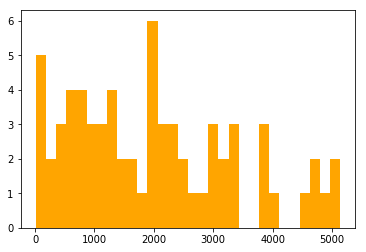

In [125]:
plt.hist(hist_start, facecolor='orange', bins=30)
plt.show()

In [128]:
start_pairs[-10:]

[(3010.0, 427, 0.0032267571468514557),
 (3060.0, 383, 0.0028942575813679333),
 (3057.0, 380, 0.0028715871564486024),
 (3080.0, 191, 0.0014433503865307448),
 (3045.0, 187, 0.0014131231533049701),
 (3039.0, 115, 0.0008690329552410244),
 (4108.0, 108, 0.0008161352970959186),
 (3009.0, 56, 0.0004231812651608467),
 (3000.0, 29, 0.00021914744088686702),
 (3053.0, 13, 9.823850798376798e-05)]

In [91]:
# Calculate intersection of most popular start and stop locations
starts.intersection(endings)

{3005.0, 3014.0, 3022.0, 3030.0, 3031.0, 3042.0, 3064.0, 3069.0, 3082.0}

In [142]:
# First calculate averaage speed for bikers
sanitized_df = df.dropna(subset=["Starting Station Latitude", "Starting Station Longitude", "Ending Station Latitude", "Ending Station Longitude", 'Duration'])

speed = []
for _, row in sanitized_df.iterrows():
    if row["Trip Route Category"] != "Round Trip":
        speed.append(geopy.distance.vincenty((row["Starting Station Latitude"], row["Starting Station Longitude"]), (row["Ending Station Latitude"], row["Ending Station Longitude"])).miles / row['Duration'])

In [180]:
mean_speed = mean(speed)
print(mean_speed)

0.0037385885722189312


In [194]:
# Use average speed to calculate round trips--cap at 20
dist_traveled = []
my_calc = []
only_nonround = []
for _, row in sanitized_df.iterrows():
    if 0.0 not in {row["Starting Station Latitude"], row["Starting Station Longitude"], row["Ending Station Latitude"], row["Ending Station Longitude"]}:
        if row["Trip Route Category"] == "Round Trip":
            final = min(row["Duration"] * mean_speed, 20)
            dist_traveled.append(final)
            my_calc.append(final)
        else:
            dist = geopy.distance.vincenty((row["Starting Station Latitude"], row["Starting Station Longitude"]), (row["Ending Station Latitude"], row["Ending Station Longitude"])).miles
            if dist > 1000:
                print((row["Starting Station Latitude"], row["Starting Station Longitude"]), (row["Ending Station Latitude"], row["Ending Station Longitude"]))
            only_nonround.append(dist)
            dist_traveled.append(dist)
    
    

In [195]:
max(only_nonround)

14.093053156005524

In [196]:
mean(dist_traveled)

1.440451568357868

In [197]:
mean(my_calc)

8.00145445674938

(array([1.31296e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+01]),
 array([   0.        ,  782.14619544, 1564.29239087, 2346.43858631,
        3128.58478174, 3910.73097718, 4692.87717261, 5475.02336805,
        6257.16956348, 7039.31575892, 7821.46195435]),
 <a list of 10 Patch objects>)

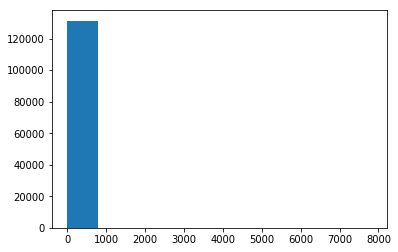

In [163]:
plt.hist(dist_traveled)

In [154]:
max(my_calc)

50

In [166]:
print(len(dist_traveled), len(my_calc))

131336 12782


In [167]:
max_calcs = 0
for x in my_calc:
    if x == 20:
        max_calcs += 1

In [168]:
max_calcs

1431

1